<a href="https://colab.research.google.com/github/ItayShalit/Intro-to-Deep-Learning/blob/main/Intro_to_DL_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torch.nn.utils import skip_init
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
import numpy as np
from sys import maxsize
from sklearn.decomposition import PCA

## Part 1


### Data Loading

In [13]:
TRAIN_SIZE = 5000
TEST_SIZE = 1000

gen = torch.generator()
gen.manual_seed(2022)

trainset = torchvision.datasets.CIFAR10(root = './data', train = True, download = True, 
                                        transform = transforms.ToTensor())
sample_train_idx = torch.randint(len(trainset), size=(TRAIN_SIZE,), generator = gen)

testset = torchvision.datasets.CIFAR10(root = './data', train = False,
                                       download = True, transform = transforms.ToTensor())
sample_test_idx = torch.randint(len(testset), size=(TEST_SIZE,), generator = gen)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Training an SVM Classifier 

In [15]:
MAX_INTENSITY = 255

train_x = trainset.data/MAX_INTENSITY
train_y = trainset.targets

test_x = testset.data/MAX_INTENSITY
test_y = testset.targets

train_x = train_x.reshape(train_x.shape[0], -1)
train_x = train_x[sample_train_idx,:]
train_y = np.array(train_y)[sample_train_idx]

test_x = test_x.reshape(test_x.shape[0], -1)
test_x = test_x[sample_test_idx,:]
test_y = np.array(test_y)[sample_test_idx]

#### Hyperparameter Tuning

In [ ]:
param_grid1 = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf']}
param_grid2 = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['linear']}

grid1 = GridSearchCV(SVC(),param_grid1, refit=True, verbose=2, n_jobs = -1)
grid2 = GridSearchCV(SVC(),param_grid1, refit=True, verbose=2, n_jobs = -1)

grid1.fit(train_x, train_y)
grid2.fit(train_x, train_y)

#### Training the Models

In [ ]:
params1 = grid1.best_params_
params2 = grid2.best_params_

rbf_model = SVC(C = params1["C"], kernel = "rbf", gamma = params1["gamma"])
linear_model = SVC(C = params2["C"], kernel = "linear", gamma = params2["gamma"])

rbf_model.fit(train_x, train_y)
linear_model.fit(train_x, train_y)

test_pred_rbf = rbf_model.predict(test_x)
test_pred_linear = linear_model.predict(test_x)

print(f"""accuracy score for linear model is: {accuracy_score(test_y, test_pred_linear)} \n 
        accuracy score for rbf model is: {accuracy_score(test_y, test_pred_rbf)}""")


## Part 2
### Baseline

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

In [2]:
class FFNeuralNetwork(nn.Module):
    def __init__(self):
        super(FFNeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        input_layer = skip_init(nn.Linear, 3072, 256) #To save computations, Parameter initialization is currently skipped, 
                                                      #and will be done before training using a custom distribution.
        hidden_layer = skip_init(nn.Linear, 256, 10)
        self.linear_relu_stack = nn.Sequential(
            input_layer,
            nn.ReLU(),
            hidden_layer,
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

NameError: ignored

In [ ]:
model = FFNeuralNetwork().to(device)
print(model)

FFNeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [10]:
def train_loop(dataloader, model, loss_fn, optimizer, print_progress = False):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if print_progress&(batch % 100 == 0):
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn, return_results = False):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    if return_results:
      return test_loss, correct

def train_and_plot_results(trainloader, testloader, model, loss_fn, optimizer, epochs, figure = None, plot_results = True, label_addition = ''):
  train_accuracy_vals, train_loss_vals, test_accuracy_vals, test_loss_vals = [], [], [], []
  for t in range(epochs):
      train_loop(trainloader, model, loss_fn, optimizer)
      train_loss, train_accuracy = test_loop(trainloader, model, loss_fn, True)
      test_loss, test_accuracy = test_loop(testloader, model, loss_fn, True)
      train_loss_vals.append(train_loss)
      train_accuracy_vals.append(train_accuracy)
      test_loss_vals.append(test_loss)
      test_accuracy_vals.append(test_accuracy)
  if figure == None:
    figure = plt.figure(figsize=(1,2))
    ax1 = figure.add_subplot(1,2,1)
    ax2 = figure.add_subplot(1,2,2) 
  ax1 = figure.get_axes()[0]
  ax2 = figure.get_axes()[1]
  line1 = ax1.plot([i for i in range(epochs)], train_accuracy_vals)
  line2 = ax1.plot([i for i in range(epochs)], test_accuracy_vals)
  line3 = ax2.plot([i for i in range(epochs)], train_loss_vals)
  line4 = ax2.plot([i for i in range(epochs)], test_loss_vals)
  
  line1.set_label('train_accuracy ' + label_addition)
  line2.set_label('test_accuracy ' + label_addition)
  line3.set_label('train_loss ' + label_addition)
  line4.set_label('test_loss  ' + label_addition)
  
  ax1.legend()
  ax2.legend()
  if plot_results:
    figure.show()

#### Hyperparameter Tuning

In [ ]:

learning_rate_vals = [1e-1, 1e-2, 1e-3]
init_std_vals = [1e-5, 1e-3, 1e-1]
momentum_param_vals = [0.9, 0.95, 0.99] 

best_loss = maxsize
best_configuration = {'learning_rate':None, 'init_std': None, momentum_param: None}

loss_fn = nn.CrossEntropyLoss()
batch_size = 64
epochs = 10

trainsubset = torch.utils.data.Subset(trainset, sample_train_idx)
testsubset = torch.utils.data.Subset(testset, sample_test_idx)
#Should sample the same samples as those I used for training and testing SVM.
trainloader = torch.utils.data.DataLoader(trainsubset, batch_size = batch_size,
                                          num_workers=2, shuffle = True)
testloader = torch.utils.data.DataLoader(testsubset, batch_size = batch_size,
                                          num_workers=2, shuffle = True)

for learning_rate in learning_rate_vals:
  for init_std in init_std_vals:
    for momentum_param in momentum_param_vals:
      torch.nn.init.normal_(model.input_layer.weight, mean=0.0, std=init_std)
      torch.nn.init.normal_(model.hidden_layer.weight, mean=0.0, std=init_std)
      optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum_param)
      for t in range(epochs):
        # print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_dataloader, model, loss_fn, optimizer)
        # test_loop(test_dataloader, model, loss_fn)
      loss, accuracy = test_loop(dataloader, model, loss_fn,  True)
      print("learning rate: ", learning_rate, "init_std: ", init_std , "momentum_param: ", momentum_param, "loss: ", loss)
      if loss<best_loss:
        best_loss = loss
        best_configuration["learning rate"] = learning_rate
        best_configuration["momentum_param"] = momentum_param
        best_configuration["init_std"] = init_std


SyntaxError: ignored

#### Plotting training procces with best configuration

In [ ]:
torch.nn.init.normal_(model.input_layer.weight, mean=0.0, std=best_configuration.init_std)
torch.nn.init.normal_(model.hidden_layer.weight, mean=0.0, std=best_configuration.init_std)
optimizer = torch.optim.SGD(model.parameters(), lr=best_configuration["learning rate"], momentum=best_configuration["momentum_param"])
train_and_plot_results(trainloader, testloader, model, loss_fn, optimizer, epochs)

#### Optimization

In [ ]:
torch.nn.init.normal_(model.input_layer.weight, mean=0.0, std=best_configuration.init_std)
torch.nn.init.normal_(model.hidden_layer.weight, mean=0.0, std=best_configuration.init_std)
optimizer = torch.optim.Adam(model.parameters(), lr=best_configuration["learning rate"], betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
train_and_plot_results(trainloader, testloader, model, loss_fn, optimizer, epochs)

#### Initialization

In [ ]:
torch.nn.init.xavier_normal_(model.input_layer.weight)
torch.nn.init.xavier_normal_(model.input_layer.weight)
optimizer = torch.optim.SGD(model.parameters(), lr=best_configuration["learning rate"], momentum=best_configuration["momentum_param"])
train_and_plot_results(trainloader, testloader, model, loss_fn, optimizer, epochs)

#### Weight Decay

In [ ]:
torch.nn.init.normal_(model.input_layer.weight, mean=0.0, std=best_configuration.init_std)
torch.nn.init.normal_(model.hidden_layer.weight, mean=0.0, std=best_configuration.init_std)
optimizer = torch.optim.SGD(model.parameters(), lr=best_configuration["learning rate"], momentum=best_configuration["momentum_param"], weight_decay=1e-4)
train_and_plot_results(trainloader, testloader, model, loss_fn, optimizer, epochs)


#### Dropout

In [7]:
class FFNeuralNetworkDropout(nn.Module):
    def __init__(self):
        super(FFNeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        input_layer = skip_init(nn.Linear, 3072, 256) #To save computations, Parameter initialization is currently skipped, 
                                                      #and will be done before training using a custom distribution.
        hidden_layer = skip_init(nn.Linear, 256, 10)
        self.dropout = nn.dropout(0.25)
        self.linear_relu_stack = nn.Sequential(
            input_layer,
            nn.dropout(0.25),
            nn.ReLU(),
            hidden_layer,
            nn.dropout(0.25)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
model = FFNeuralNetworkDropout().to(device)
torch.nn.init.normal_(model.input_layer.weight, mean=0.0, std=best_configuration.init_std)
torch.nn.init.normal_(model.hidden_layer.weight, mean=0.0, std=best_configuration.init_std)
optimizer = torch.optim.SGD(model.parameters(), lr=best_configuration["learning rate"], momentum=best_configuration["momentum_param"], weight_decay=1e-4)
train_and_plot_results(trainloader, testloader, model, loss_fn, optimizer, epochs)


#### PCA Whitening

In [25]:
class FFNeuralNetwork(nn.Module):
    def __init__(self):
        super(FFNeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        input_layer = skip_init(nn.Linear, 20, 256) #To save computations, Parameter initialization is currently skipped, 
                                                      #and will be done before training using a custom distribution.
        hidden_layer = skip_init(nn.Linear, 256, 10)
        self.linear_relu_stack = nn.Sequential(
            input_layer,
            nn.ReLU(),
            hidden_layer,
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

pca = PCA(n_components=20, whiten=True, random_state=10)
train_x_pca = pca.fit_transform(train_x)
test_x_pca = pca.fit_transform(test_x)
tensor_trainx = torch.Tensor(train_x_pca)
tensor_trainy = torch.Tensor(train_y)
tensor_testx = torch.Tensor(test_x_pca)
tensor_testy = torch.Tensor(test_y)

trainset_pca = torch.utils.data.TensorDataset(tensor_trainx,tensor_trainy)
testset_pca = torch.utils.data.TensorDataset(tensor_testx,tensor_testy)

trainsubset_pca = torch.utils.data.Subset(trainset_pca, sample_train_idx)
testsubset_pca = torch.utils.data.Subset(testset_pca, sample_test_idx)
#Should sample the same samples as those I used for training and testing SVM.
trainloader_pca = torch.utils.data.DataLoader(trainsubset_pca, batch_size = batch_size,
                                          num_workers=2, shuffle = True)
testloader_pca = torch.utils.data.DataLoader(testsubset_pca, batch_size = batch_size,
                                          num_workers=2, shuffle = True)

torch.nn.init.normal_(model.input_layer.weight, mean=0.0, std=best_configuration.init_std)
torch.nn.init.normal_(model.hidden_layer.weight, mean=0.0, std=best_configuration.init_std)
optimizer = torch.optim.SGD(model.parameters(), lr=best_configuration["learning rate"], momentum=best_configuration["momentum_param"])
train_and_plot_results(trainloader_pca, testloader_pca, model, loss_fn, optimizer, epochs)

#### Network Width

NameError: ignored

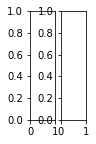

In [11]:
def NNClassGeneratorByWidth(width):
  class FFNeuralNetwork(nn.Module):
      def __init__(self):
          super(FFNeuralNetwork, self).__init__()
          self.flatten = nn.Flatten()
          input_layer = skip_init(nn.Linear, 3072, width) #To save computations, Parameter initialization is currently skipped, 
                                                        #and will be done before training using a custom distribution.
          hidden_layer = skip_init(nn.Linear, width, 10)
          self.linear_relu_stack = nn.Sequential(
              input_layer,
              nn.ReLU(),
              hidden_layer,
          )

      def forward(self, x):
          x = self.flatten(x)
          logits = self.linear_relu_stack(x)
          return logits
  return FFNeuralNetwork

figure = plt.figure(figsize=(1,2))
ax1 = figure.add_subplot(1,2,1)
ax2 = figure.add_subplot(1,2,2) 
width_vals = [6, 10, 12]

for width in width_vals:
  NNClass = NNClassGeneratorByWidth(2**width)
  model = NNClass().to(device)
  torch.nn.init.normal_(model.input_layer.weight, mean=0.0, std=best_configuration.init_std)
  torch.nn.init.normal_(model.hidden_layer.weight, mean=0.0, std=best_configuration.init_std)
  optimizer = torch.optim.SGD(model.parameters(), lr=best_configuration["learning rate"], momentum=best_configuration["momentum_param"])
  train_and_plot_results(trainloader, testloader, model, loss_fn, optimizer, epochs, figure = figure, plot_results = False, label_addition = f'width 2^{width}')

figure.show()
  

#### Network Depth

In [ ]:
def NNClassGeneratorByDepth(depth):
  class FFNeuralNetwork(nn.Module):
      def __init__(self):
          super(FFNeuralNetwork, self).__init__()
          self.flatten = nn.Flatten()
          sequence = [skip_init(nn.Linear, 3072, 64)]
          for i in range(depth-1):
            sequence.append(nn.ReLU())
            sequence.append(skip_init(nn.Linear, 64, 64))
          sequence.append(nn.ReLU())
          sequence.append(skip_init(nn.Linear, 64, 10))
          self.linear_relu_stack = nn.Sequential(sequence)

      def forward(self, x):
          x = self.flatten(x)
          logits = self.linear_relu_stack(x)
          return logits
  return FFNeuralNetwork




In [ ]:
figure = plt.figure(figsize=(1,2))
ax1 = figure.add_subplot(1,2,1)
ax2 = figure.add_subplot(1,2,2) 
depth_vals = [6, 10, 12]

for depth in depth_vals:
  NNClass = NNClassGeneratorByDepth(depth)
  model = NNClass().to(device)
  torch.nn.init.normal_(model.input_layer.weight, mean=0.0, std=best_configuration.init_std)
  torch.nn.init.normal_(model.hidden_layer.weight, mean=0.0, std=best_configuration.init_std)
  optimizer = torch.optim.SGD(model.parameters(), lr=best_configuration["learning rate"], momentum=best_configuration["momentum_param"])
  train_and_plot_results(trainloader, testloader, model, loss_fn, optimizer, epochs, figure = figure, plot_results = False, label_addition = f'depth {depth}')

figure.show()
